This document includes exploratory data analysis and predictive modeling aimed at answering our primary question: **What factors lead to movie success, where success is defined quantitatively by the average vote rating?**

## EDA

In this section, we look at genre impact, temporal trends, star power, and linguistic influence. We also consider feature distributions of financial variables, and perform correlation analysis to understand the relationship between several numerical features.

In [1]:
import pandas as pd 

df = pd.read_csv("final_movie_table.csv")

In [2]:
df.head()

,movie_id,movie_name,budget,genres,original_language,original_title,release_date,release_year,revenue,runtime,status,adult,vote_average,vote_count,lead_actor,keyword_count,user_avg_rating,user_rating_count
0,862,Toy Story,30000000,Animation|Comedy|Family,en,Toy Story,1995-10-30,1995.0,373554033.0,81.0,Released,False,7.7,5415.0,Tom Hanks,9.0,3.888157,66008.0
1,8844,Jumanji,65000000,Adventure|Fantasy|Family,en,Jumanji,1995-12-15,1995.0,262797249.0,104.0,Released,False,6.9,2413.0,Robin Williams,6.0,3.236953,26060.0
2,15602,Grumpier Old Men,0,Romance|Comedy,en,Grumpier Old Men,1995-12-22,1995.0,0.0,101.0,Released,False,6.5,92.0,Walter Matthau,4.0,3.175550,15497.0
3,31357,Waiting to Exhale,16000000,Comedy|Drama|Romance,en,Waiting to Exhale,1995-12-22,1995.0,81452156.0,127.0,Released,False,6.1,34.0,Whitney Houston,5.0,2.875713,2981.0
4,11862,Father of the Bride Part II,0,Comedy,en,Father of the Bride Part II,1995-02-10,1995.0,76578911.0,106.0,Released,False,5.7,173.0,Steve Martin,9.0,3.079565,15258.0


In [3]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46629 entries, 0 to 46628
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           46629 non-null  int64  
 1   movie_name         46625 non-null  object 
 2   budget             46629 non-null  int64  
 3   genres             44104 non-null  object 
 4   original_language  46618 non-null  object 
 5   original_title     46629 non-null  object 
 6   release_date       46541 non-null  object 
 7   release_year       46541 non-null  float64
 8   revenue            46625 non-null  float64
 9   runtime            46361 non-null  float64
 10  status             46543 non-null  object 
 11  adult              46629 non-null  bool   
 12  vote_average       46625 non-null  float64
 13  vote_count         46625 non-null  float64
 14  lead_actor         44137 non-null  object 
 15  keyword_count      46628 non-null  float64
 16  user_avg_rating    458

movie_id                0
movie_name              4
budget                  0
genres               2525
original_language      11
original_title          0
release_date           88
release_year           88
revenue                 4
runtime               268
status                 86
adult                   0
vote_average            4
vote_count              4
lead_actor           2492
keyword_count           1
user_avg_rating       745
user_rating_count     745
dtype: int64

#### **Genre Impact:** Which movie genres typically receive the highest critical acclaim (average rating) from audiences, and which receive the lowest?

In [4]:
df_genres = (
    df.assign(genre=df['genres'].str.split('|'))
      .explode('genre')
)

genre_vote_avg = (
    df_genres.groupby('genre')['vote_average']
             .mean()
             .sort_values(ascending=False)
             .reset_index()
)

genre_counts = (
    df_genres['genre']
        .value_counts()
        .reset_index()
)

genre_counts.columns = ['genre', 'count']

genre_summary = genre_vote_avg.merge(genre_counts, on='genre')

genre_summary

,genre,vote_average,count
0,Animation,6.271407,1998
1,History,6.157814,1427
2,War,6.036573,1348
3,Drama,5.892609,20809
4,Music,5.878528,1630
5,Crime,5.875427,4387
6,Mystery,5.824085,2541
7,Documentary,5.811136,4050
8,Romance,5.791492,6923
9,Fantasy,5.762348,2385


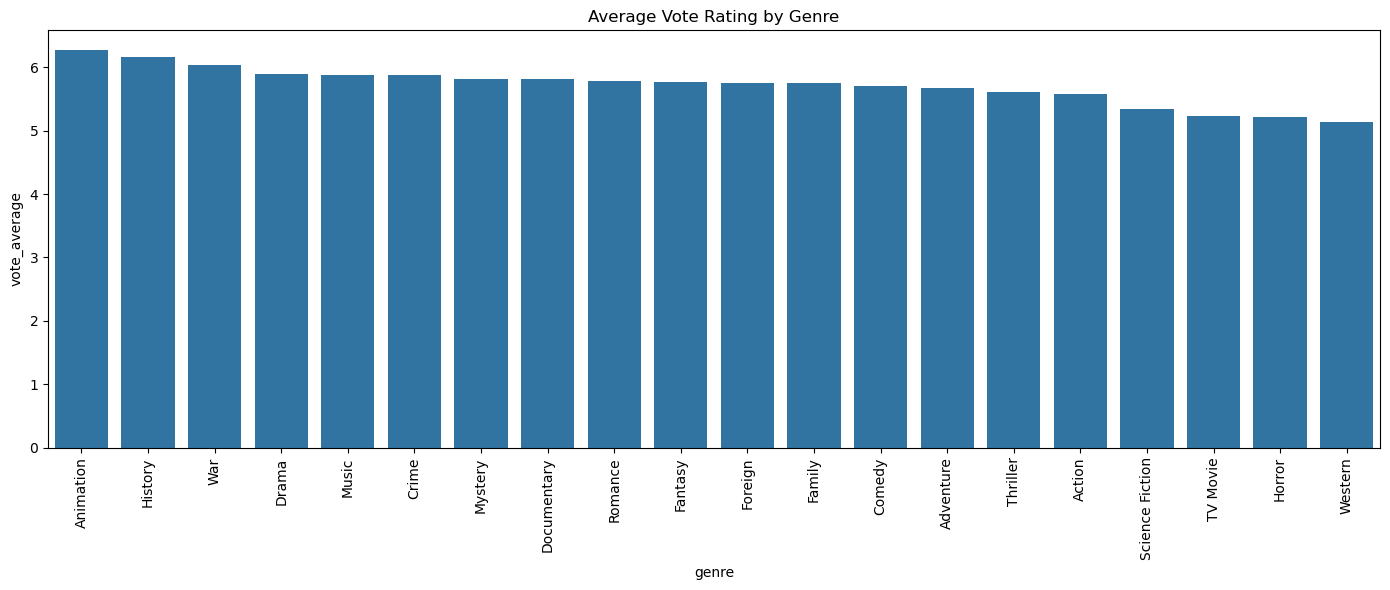

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

genre_summary_sorted = genre_summary.sort_values('vote_average', ascending=False)

plt.figure(figsize=(14,6))
sns.barplot(
    data=genre_summary_sorted,
    x='genre',
    y='vote_average'
)
plt.xticks(rotation=90)
plt.title('Average Vote Rating by Genre')
plt.tight_layout()
plt.show()

The visualization shows that Animation, History, and War films receive the highest average ratings, while genres like Western, Horror, and TV Movie score lower.

#### **Temporal Trends:** How does the era of release influence a movie's average rating?

In [6]:
# Drop missing years
df_year = df.dropna(subset=['release_year']).copy()

# Convert release_year to int and then to category
df_year['release_year'] = df_year['release_year'].astype(int)
df_year['release_year_cat'] = df_year['release_year'].astype('category')

In [7]:
def categorize_year(y):
    if y < 1920:  return 'Pre-1920'
    elif y < 1950: return '1920–1949'
    elif y < 1980: return '1950–1979'
    elif y < 2000: return '1980–1999'
    elif y < 2010: return '2000–2009'
    else: return '2010–2019'   # everything 2010–2019

df_year['year_group'] = df_year['release_year'].apply(categorize_year)
df_year['year_group'] = df_year['year_group'].astype('category')

In [8]:
year_group_summary = (
    df_year.groupby('year_group')
           .agg(
               vote_average_mean=('vote_average', 'mean'),
               movie_count=('movie_id', 'count')
           )
           .reset_index()
           .sort_values('year_group')
)

year_group_summary

/var/folders/vs/6_7m30556xz7sfpjhfw5bn240000gn/T/ipykernel_53655/1902286050.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_year.groupby('year_group')


,year_group,vote_average_mean,movie_count
0,1920–1949,5.367426,3337
1,1950–1979,5.665494,8332
2,1980–1999,5.566091,9729
3,2000–2009,5.588039,11479
4,2010–2019,5.718380,13319
5,Pre-1920,5.387246,345


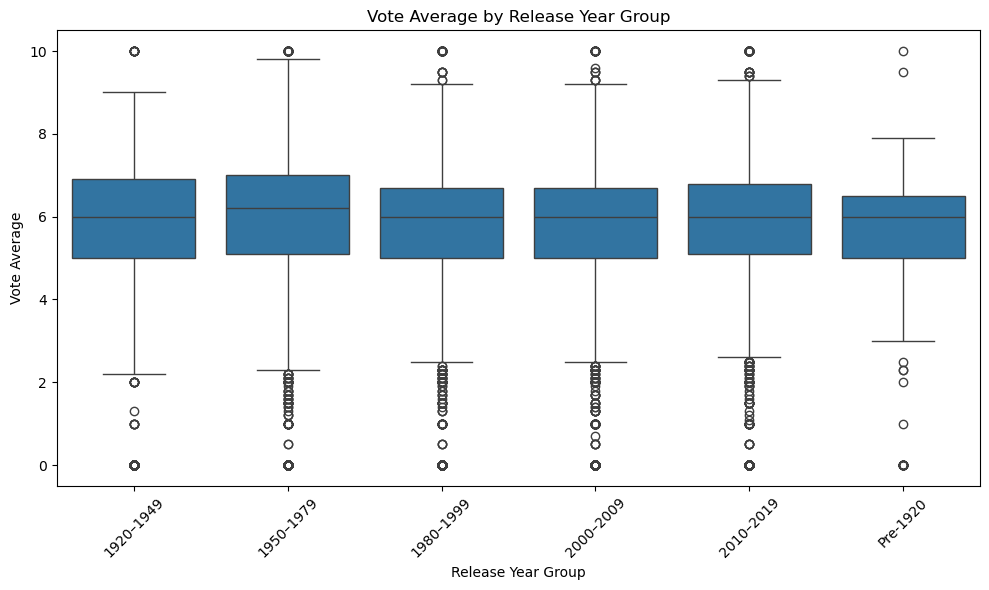

In [9]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_year, x='year_group', y='vote_average')
plt.xticks(rotation=45)
plt.title('Vote Average by Release Year Group')
plt.xlabel('Release Year Group')
plt.ylabel('Vote Average')
plt.tight_layout()
plt.show()

We grouped release years into broader historical categories to reduce noise from sparse early-year data and make long term patterns easier to compare. Across the boxplot, average ratings remain fairly stable over time, with only small fluctuations between groups. There is no strong upward or downward trend, suggesting that audience ratings have been consistent across decades despite changes in filmmaking style and industry growth.

#### **Star Power:** Does the popularity of the lead actor seem to correlate with average rating?

In [10]:
# Filter out missing lead_actor
df_actor = df.dropna(subset=['lead_actor'])

# Compute average vote and movie count
actor_summary = (
    df_actor.groupby('lead_actor')
            .agg(
                vote_average_mean=('vote_average', 'mean'),
                movie_count=('movie_id', 'count')
            )
            .reset_index()
)

# Sort by rating
actor_summary = actor_summary.sort_values('vote_average_mean', ascending=False)

actor_summary

,lead_actor,vote_average_mean,movie_count
2706,Chai Fonacier,10.0,1
10915,Mang Fely,10.0,1
6277,Hadi Alipour,10.0,1
13783,Phillip Avalon,10.0,1
4138,Diane Bellego,10.0,1
...,...,...,...
11723,Meg Foster,0.0,1
7763,Jena Friedman,0.0,1
16037,Stefania D'Amario,0.0,1
8651,Joshua Coleman,0.0,1


In [11]:
def classify_popularity(n):
    if n >= 10:
        return 'High Popularity'
    elif n >= 5:
        return 'Medium Popularity'
    else:
        return 'Low Popularity'

actor_summary['popularity_group'] = actor_summary['movie_count'].apply(classify_popularity)

In [12]:
popularity_rating_summary = (
    actor_summary
      .groupby('popularity_group')['vote_average_mean']
      .mean()
      .reset_index()
      .sort_values('vote_average_mean', ascending=False)
)

popularity_rating_summary

,popularity_group,vote_average_mean
0,High Popularity,5.868319
2,Medium Popularity,5.666178
1,Low Popularity,5.490776


In [13]:
actor_summary['popularity_group'].value_counts()

popularity_group
Low Popularity       16488
Medium Popularity     1140
High Popularity        745
Name: count, dtype: int64

/var/folders/vs/6_7m30556xz7sfpjhfw5bn240000gn/T/ipykernel_53655/451300828.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


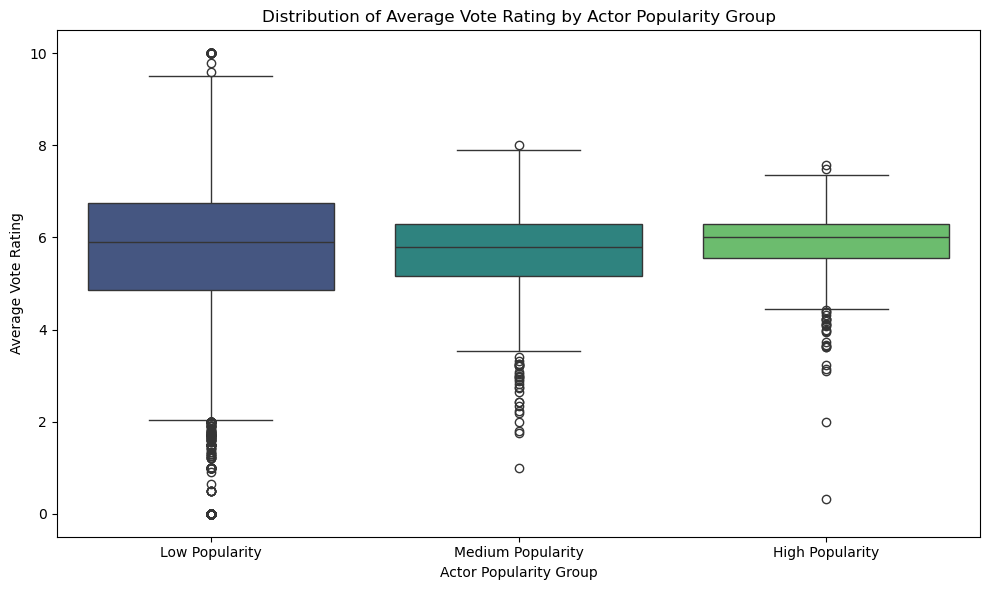

In [14]:
plt.figure(figsize=(10,6))

sns.boxplot(
    data=actor_summary,
    x='popularity_group',
    y='vote_average_mean',
    palette='viridis'
)

plt.title('Distribution of Average Vote Rating by Actor Popularity Group')
plt.xlabel('Actor Popularity Group')
plt.ylabel('Average Vote Rating')
plt.tight_layout()
plt.show()

We grouped actors into popularity tiers based on the number of movies they appeared in: High Popularity (10+ movies), Medium Popularity (5–9 movies), and Low Popularity (fewer than 5 movies). This produced group sizes of 745 high-popularity actors, 1,148 medium-popularity actors, and 16,488 low-popularity actors. The boxplot shows that, while differences are modest, high-popularity actors tend to appear in slightly better-rated films on average, with a higher median vote score and fewer extreme low-rating outliers. Low-popularity actors show the widest spread, indicating more variability in film quality for performers with limited filmographies.


#### **Linguistic Influence:** How does the original language of a film affect its average rating?

In [15]:
df_lang = df.dropna(subset=['original_language'])

language_summary = (
    df_lang.groupby('original_language')
           .agg(
               vote_average_mean=('vote_average', 'mean'),
               movie_count=('movie_id', 'count')
           )
           .reset_index()
           .sort_values('movie_count', ascending=False)
)

language_summary

,original_language,vote_average_mean,movie_count
17,en,5.483561,32937
24,fr,6.038867,2524
34,it,5.437061,1565
36,ja,6.246300,1420
15,de,5.846445,1111
...,...,...,...
25,fy,0.000000,1
18,eo,4.300000,1
13,cy,6.500000,1
4,ay,6.000000,1


In [16]:
# Filter for languages with at least 500 movies
lang_big = language_summary[language_summary['movie_count'] >= 500]

lang_big

,original_language,vote_average_mean,movie_count
17,en,5.483561,32937
24,fr,6.038867,2524
34,it,5.437061,1565
36,ja,6.246300,1420
15,de,5.846445,1111
19,es,5.686076,1027
65,ru,5.702151,837
28,hi,5.794747,533


In [17]:
# Language code → full name mapping
lang_map = {
    'en': 'English',
    'fr': 'French',
    'it': 'Italian',
    'ja': 'Japanese',
    'de': 'German',
    'ru': 'Russian',
    'hi': 'Hindi'
}

# Apply mapping (fallback: keep code if not mapped)
df_lang_big['language_full'] = df_lang_big['original_language'].map(lang_map)

NameError: name 'df_lang_big' is not defined

/var/folders/jd/kgmmf40n35d3bhgwcsrqn78r0000gn/T/ipykernel_25188/1945161644.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


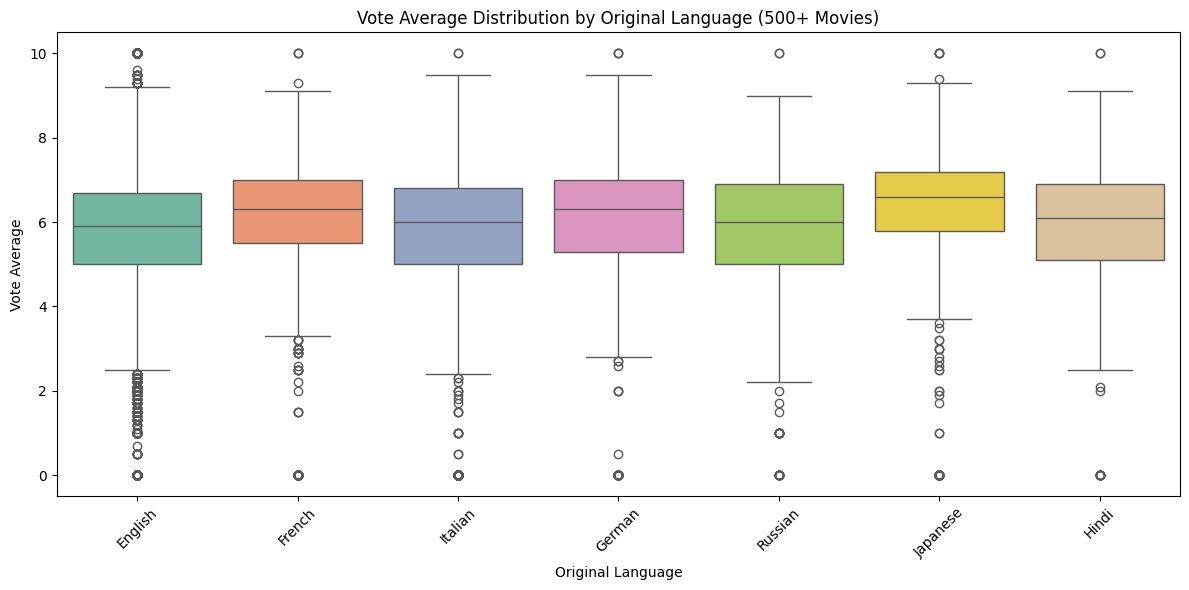

In [ ]:
plt.figure(figsize=(12,6))

sns.boxplot(
    data=df_lang_big,
    x='language_full',
    y='vote_average',
    palette='Set2'
)

plt.title('Vote Average Distribution by Original Language (500+ Movies)')
plt.xlabel('Original Language')
plt.ylabel('Vote Average')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

To analyze language effects, we restricted the dataset to languages with at least 500 films and created a cleaned classification that mapped language codes to their full names. The resulting visualization shows clear differences in average ratings across linguistic groups. Japanese and French films tend to receive noticeably higher vote averages, with medians above most other languages and tighter clustering among higher ratings. English films dominate the dataset numerically but show a broader distribution with many lower-rated entries, which lowers their overall median. German, Italian, Russian, and Hindi films fall in a middle band, each showing moderate central ratings but differing in the spread of outliers. These patterns likely reflect differences in film volume, cultural rating tendencies, and variation in production styles across regions.


#### **Adult Films:** Does the status of a film as 'adult' impact its average rating? 

In [ ]:
df_adult = df.dropna(subset=['adult'])

adult_summary = (
    df_adult
        .groupby('adult')
        .agg(
            vote_average_mean = ('vote_average', 'mean'),
            movie_count       = ('movie_id', 'count')
        )
        .reset_index()
)

adult_summary

,adult,vote_average_mean,movie_count
0,False,5.611934,46620
1,True,3.922222,9


/var/folders/jd/kgmmf40n35d3bhgwcsrqn78r0000gn/T/ipykernel_25188/1349330158.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


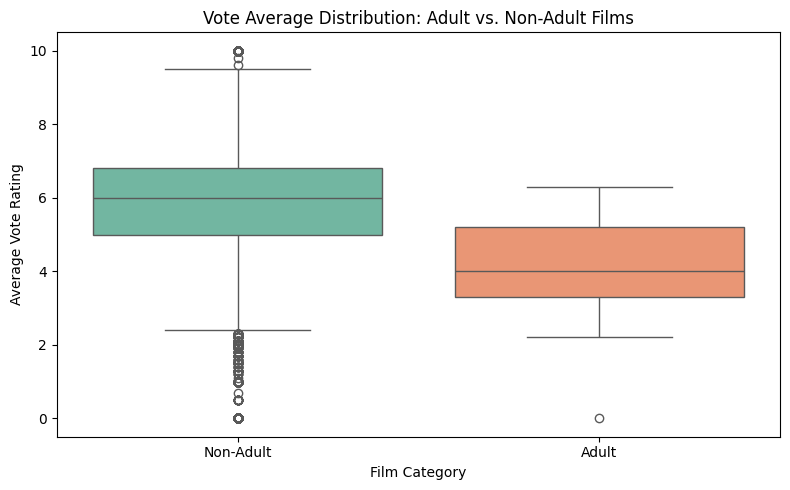

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=df_adult,
    x='adult',
    y='vote_average',
    palette='Set2'
)

plt.xticks([0,1], ['Non-Adult', 'Adult'])
plt.xlabel('Film Category')
plt.ylabel('Average Vote Rating')
plt.title('Vote Average Distribution: Adult vs. Non-Adult Films')
plt.tight_layout()
plt.show()

We compared vote averages between adult and non-adult films by grouping titles using the dataset’s adult indicator. Non-adult movies make up nearly the entire dataset, while adult films account for only nine titles, which limits interpretability but still reveals a clear pattern. Adult-rated films show noticeably lower average ratings and a compressed distribution, while non-adult films span a wider range and have a higher median rating. This suggests that adult films tend to receive less favorable audience evaluations overall.

### Numerical Variables

Up to this point, we've been looking at the impact of various categorical variables on average rating.

Now we will look at some numerical variables as well.

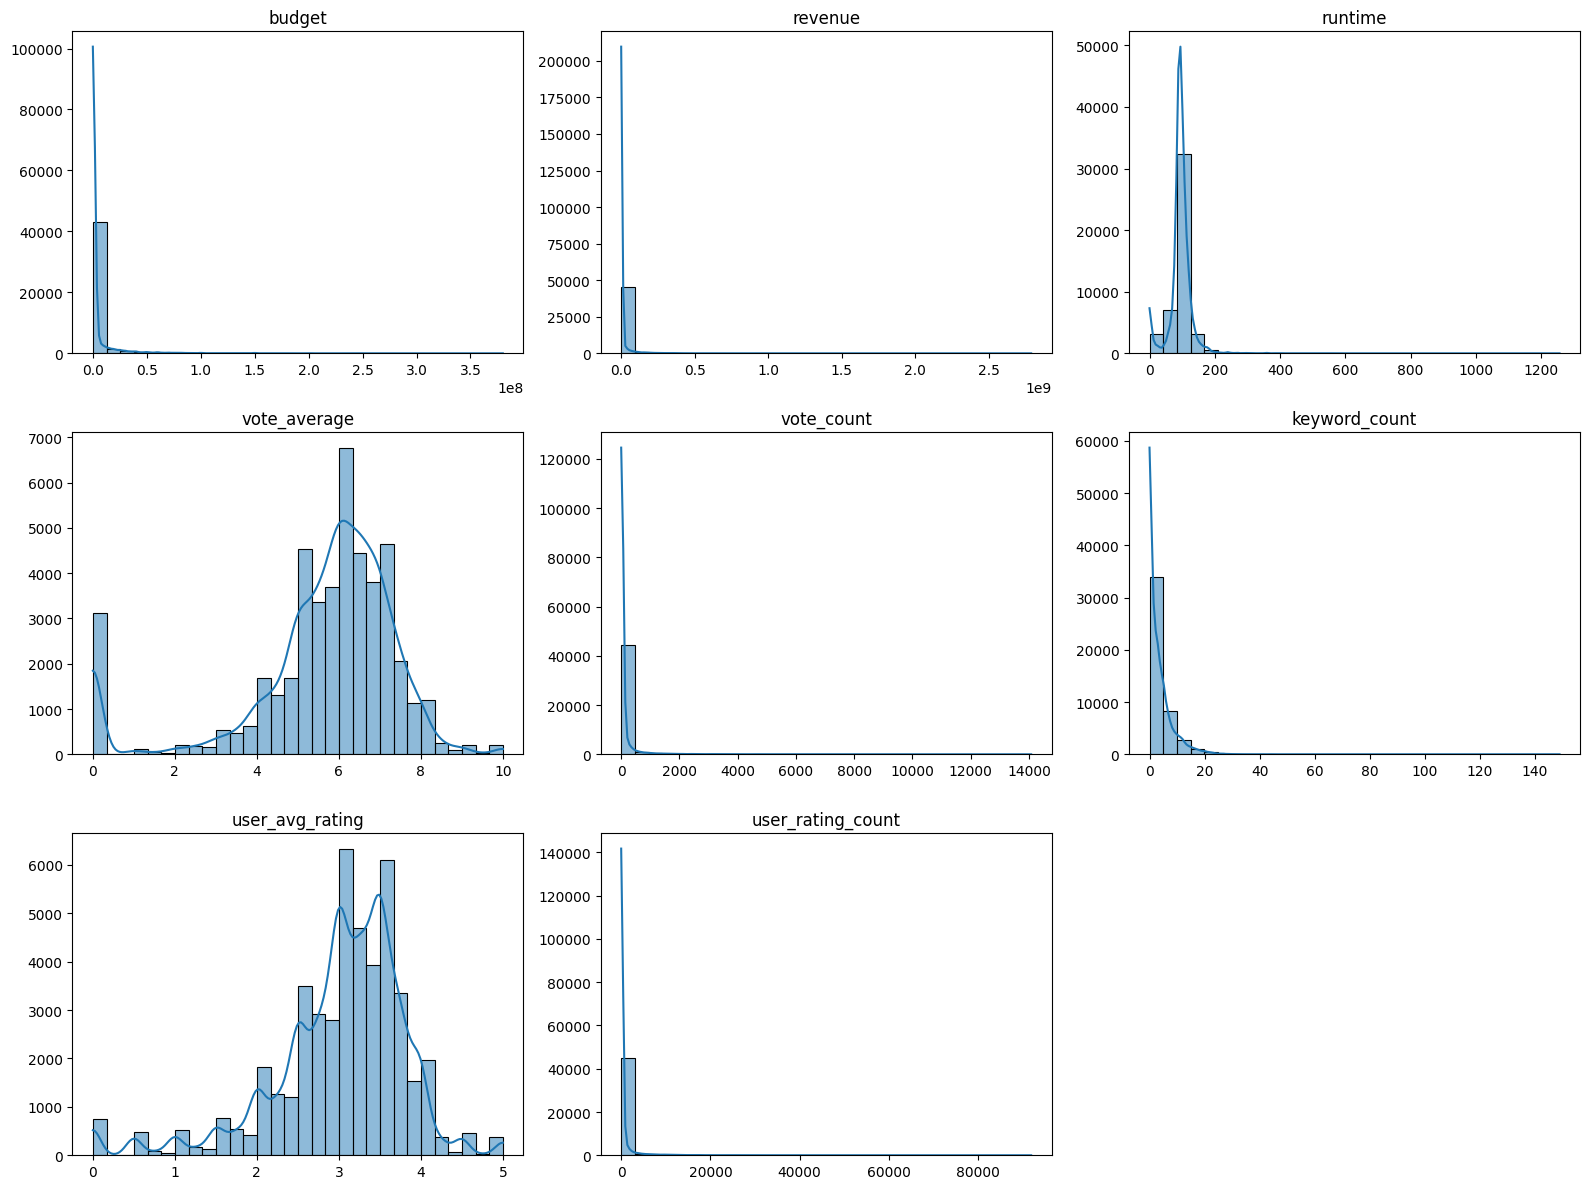

In [ ]:
df = df.dropna(subset=['vote_average', 'vote_count'])

df['user_avg_rating'] = df['user_avg_rating'].fillna(0)
df['user_rating_count'] = df['user_rating_count'].fillna(0)

df['runtime'] = df['runtime'].fillna(df['runtime'].median())



numeric_vars = [
    'budget', 'revenue', 'runtime', 'vote_average',
    'vote_count', 'keyword_count', 'user_avg_rating',
    'user_rating_count'
]

plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_vars, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

We first removed rows missing vote_average or vote_count, since these variables are essential for our analysis and only a very small number of records were affected. For user rating fields (user_avg_rating and user_rating_count), missing values were imputed with zero, which reflects the meaningful condition that a movie has no user ratings rather than a missing measurement. For runtime, which had more missing entries, we imputed using the median runtime to preserve the overall distribution without being overly influenced by extreme runtimes. All other fields were left unchanged because they were either categorical, sparsely missing, or not required for numeric visualization.

Most numerical variables exhibit strong right skew, including budget, revenue, vote_count, keyword_count, and user_rating_count, where the majority of values are low with a long tail of very large values. Runtime is also right skewed but with a more compact range. In contrast, vote_average and user_avg_rating are approximately bell shaped, showing symmetric distributions centered around their typical rating values. These patterns are consistent with movie industry data where a small number of films accumulate very high budgets, revenues, or rating counts.

We will apply log transformation to the following variables to reduce extreme skew and improve interpretability in later modeling:
- budget
- revenue
- vote_count
- keyword_count
- user_rating_count

These variables span several orders of magnitude, and the log transform will compress their long right tails, stabilize variance, and make relationships more linear and more suitable for regression or clustering. Runtime, vote_average, and user_avg_rating do not require log transformation because their distributions are already well behaved.


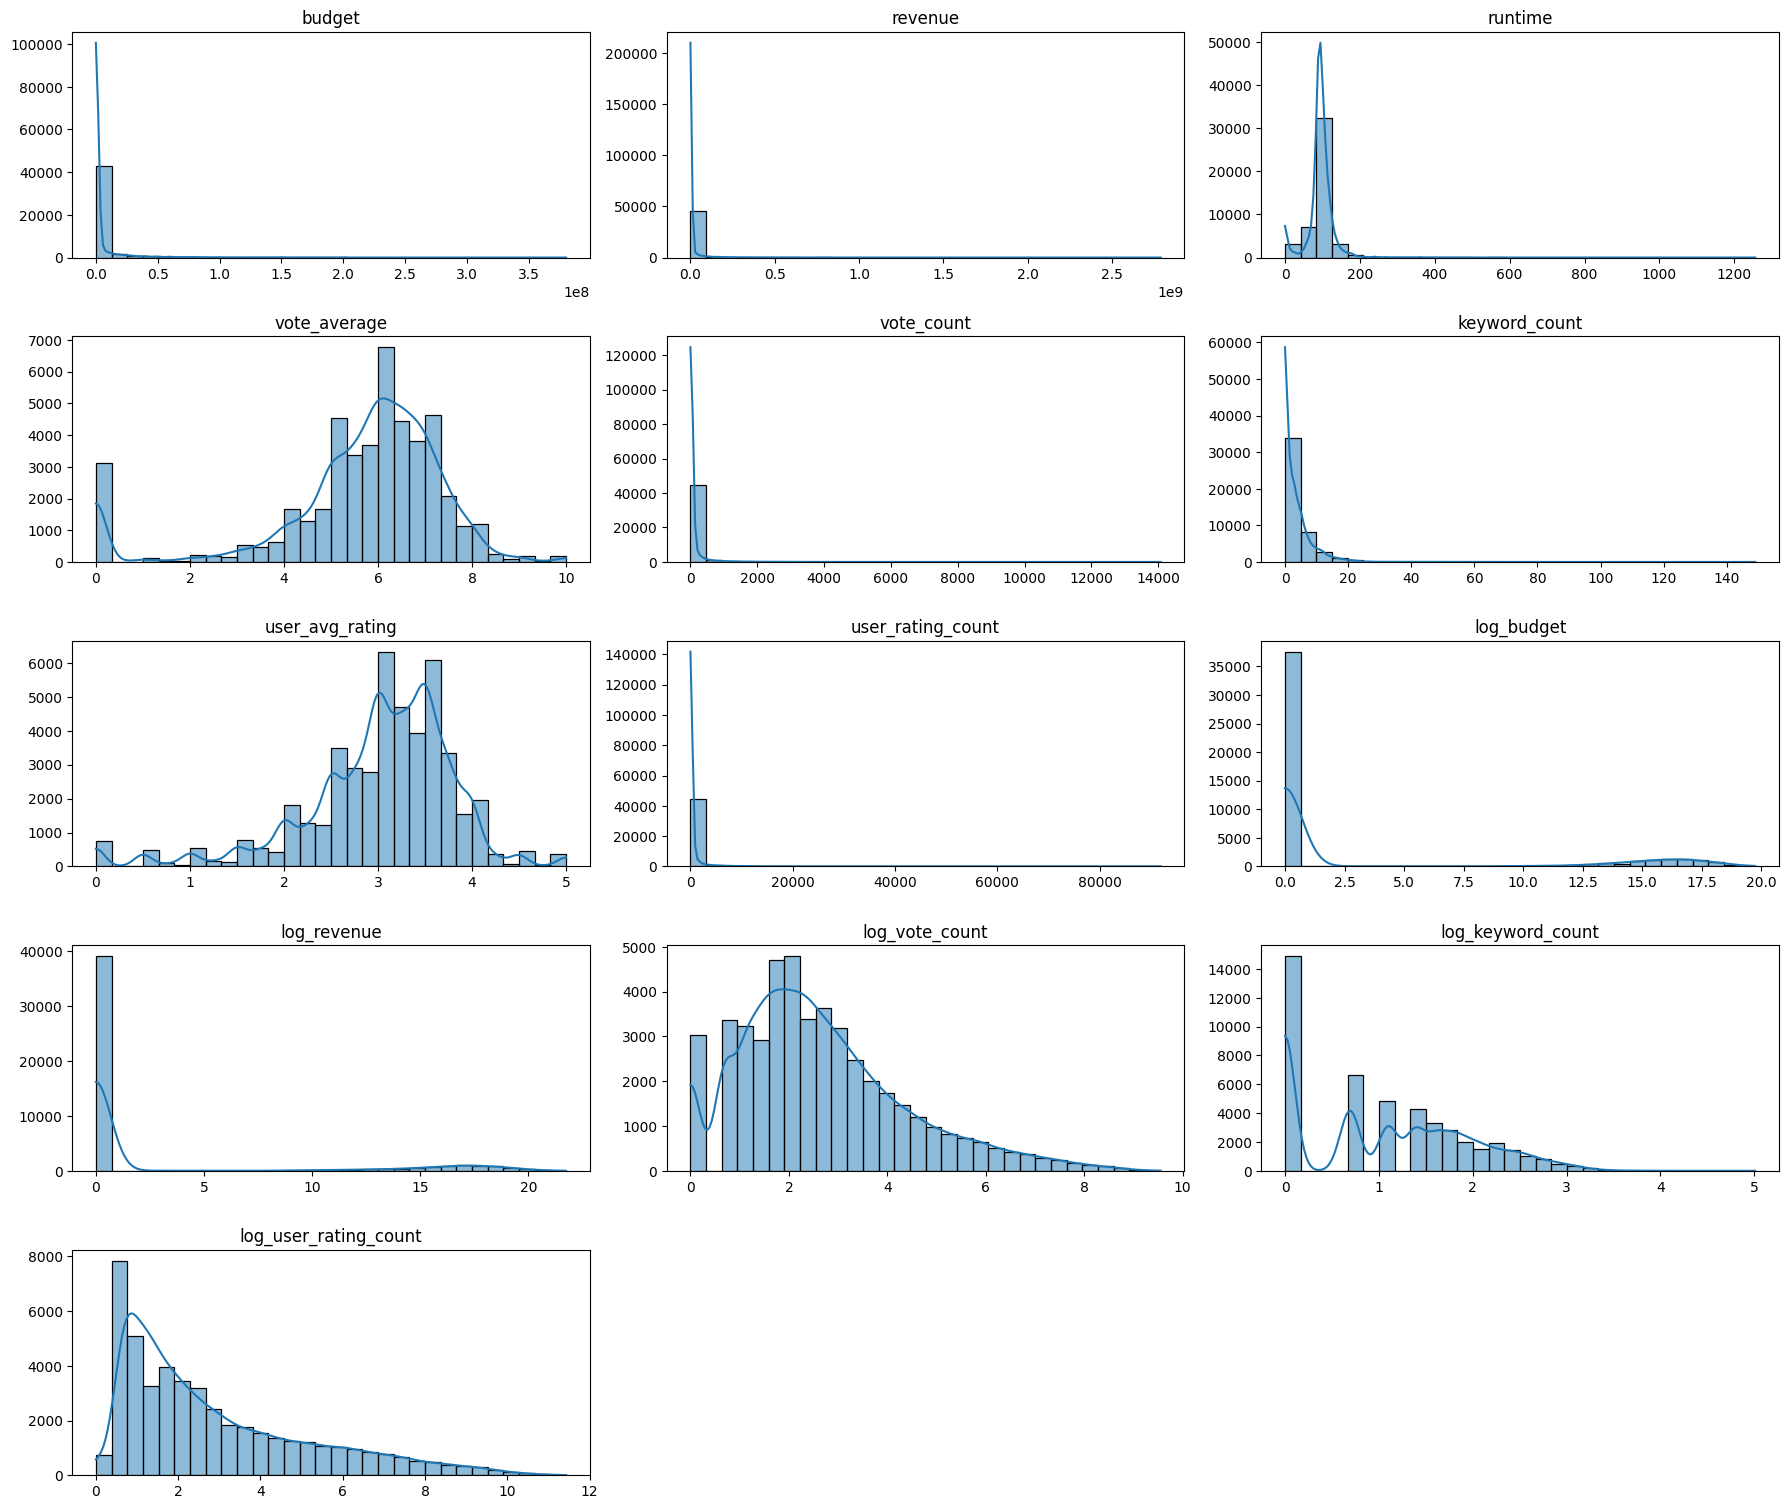

In [ ]:
import numpy as np

log_vars = [
    'budget', 'revenue', 'vote_count',
    'keyword_count', 'user_rating_count'
]

# Create log-transformed versions (using log1p to handle zeros)
for col in log_vars:
    df[f'log_{col}'] = np.log1p(df[col])

# Re-visualize numerical variables including log versions
numeric_vars = [
    'budget', 'revenue', 'runtime', 'vote_average',
    'vote_count', 'keyword_count', 'user_avg_rating',
    'user_rating_count',
    'log_budget', 'log_revenue', 'log_vote_count',
    'log_keyword_count', 'log_user_rating_count'
]

plt.figure(figsize=(18, 18))

for i, col in enumerate(numeric_vars, 1):
    plt.subplot(6, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

The log transformations substantially improved the distributions of the most skewed numerical variables. Budget, revenue, vote_count, keyword_count, and user_rating_count all shifted from extreme right skew with long tails to much more compact and interpretable shapes after applying log1p. While these transformed variables are not perfectly normal, they now show smoother, more symmetric distributions with compressed outliers, making them far better suited for correlation analysis and modeling. The normally distributed variables, such as vote_average and user_avg_rating, remained unchanged, and runtime continues to show a reasonable distribution without transformation. Overall, the dataset is now far more balanced and appropriate for downstream statistical or machine learning tasks.

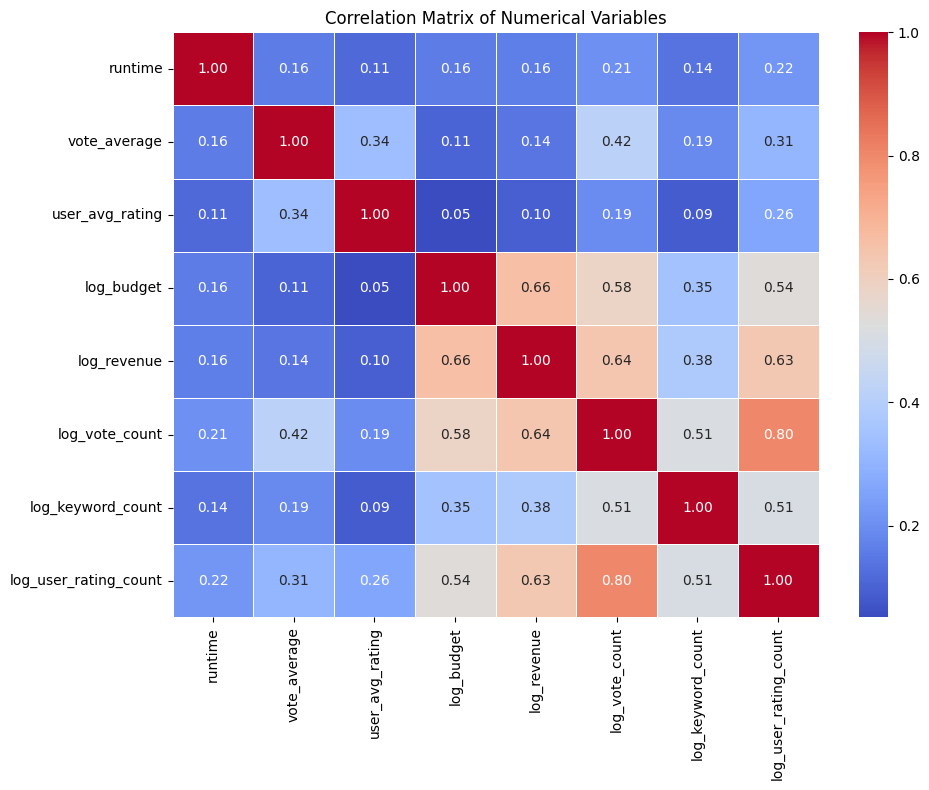

In [ ]:
# Select numerical variables for correlation
corr_vars = [
    'runtime',
    'vote_average',
    'user_avg_rating',
    'log_budget',
    'log_revenue',
    'log_vote_count',
    'log_keyword_count',
    'log_user_rating_count'
]

corr_matrix = df[corr_vars].corr()

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()

The correlation matrix shows a few clear and intuitive relationships among the numerical variables. The strongest correlations appear among the popularity-related measures: log_vote_count and log_user_rating_count have a very high correlation (0.80), indicating that movies receiving more votes on TMDB also tend to receive more user ratings across platforms. Log_revenue is also strongly correlated with both log_vote_count (0.64) and log_user_rating_count (0.63), suggesting that commercially successful films tend to have larger audiences and thus accumulate more user engagement. Log_budget shows moderate correlation with revenue (0.66) and vote_count (0.58), which aligns with expectations that higher-budget films typically receive more attention and generate more earnings.

On the other hand, vote_average and user_avg_rating, which reflect quality perception, have relatively weak correlations with the other variables. Vote_average correlates only modestly with vote_count (0.42) and user_rating_count (0.31), meaning popular movies are not necessarily higher-rated. Runtime also shows weak associations with all variables, suggesting film length does not meaningfully predict popularity or perceived quality. Overall, the main relationships cluster around popularity and audience engagement rather than rating metrics, highlighting that commercial reach and public perception behave differently from measured film quality.

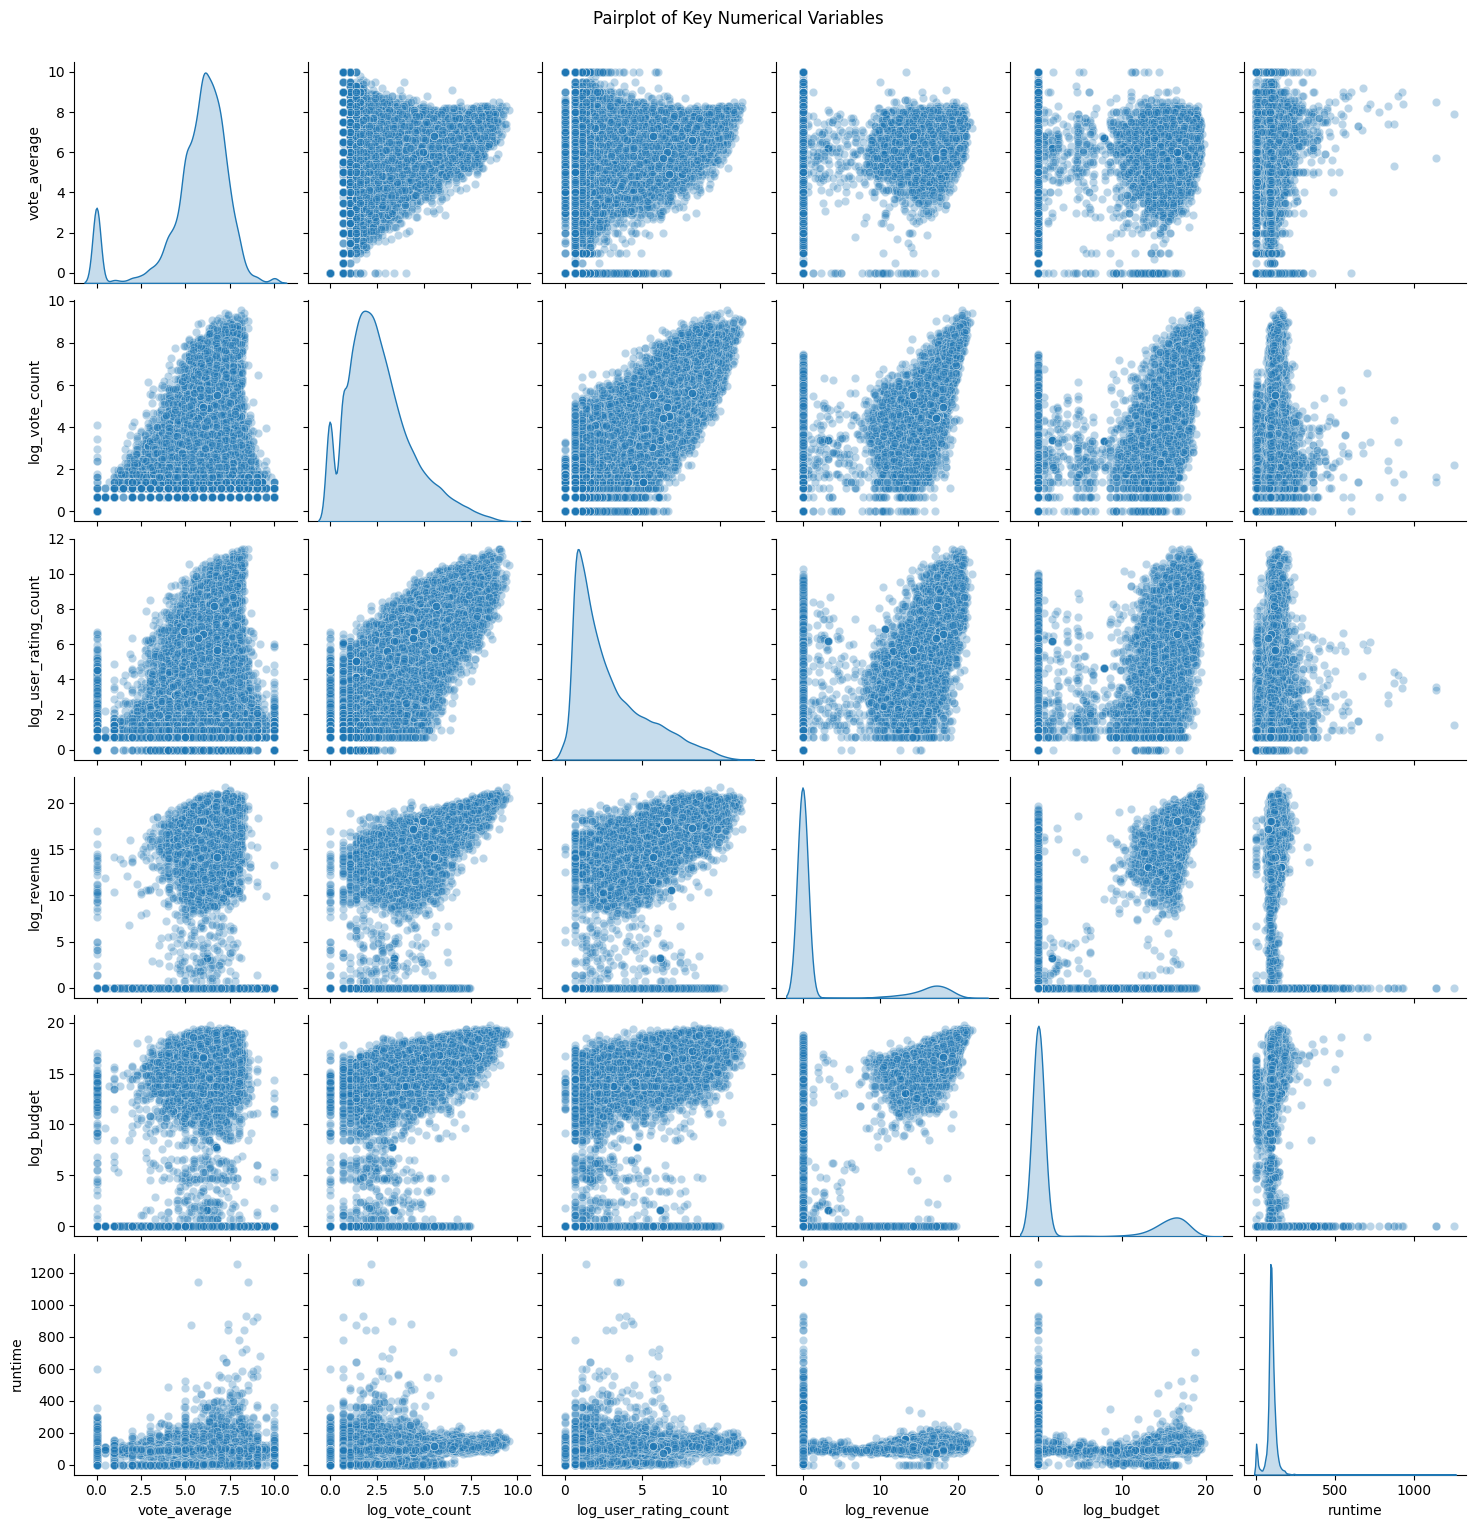

In [ ]:
pairplot_vars = [
    'vote_average',
    'log_vote_count',
    'log_user_rating_count',
    'log_revenue',
    'log_budget',
    'runtime'
]

sns.pairplot(
    df[pairplot_vars],
    diag_kind='kde',
    plot_kws={'alpha': 0.3}
)
plt.suptitle("Pairplot of Key Numerical Variables", y=1.02)
plt.show()

The pairplot highlights the relationships between the main numerical predictors after log transformation. Most scatterplots remain diffuse with no strong linear patterns, but a few trends stand out. Log vote count, log user rating count, and log revenue all show mild positive relationships with each other, which is expected given they reflect audience engagement and popularity. Runtime shows little structured association with the log-scaled variables, though a slight upward trend appears with vote average. Overall, the pairplot supports the idea that popularity metrics are interrelated, while budget and runtime behave more independently.


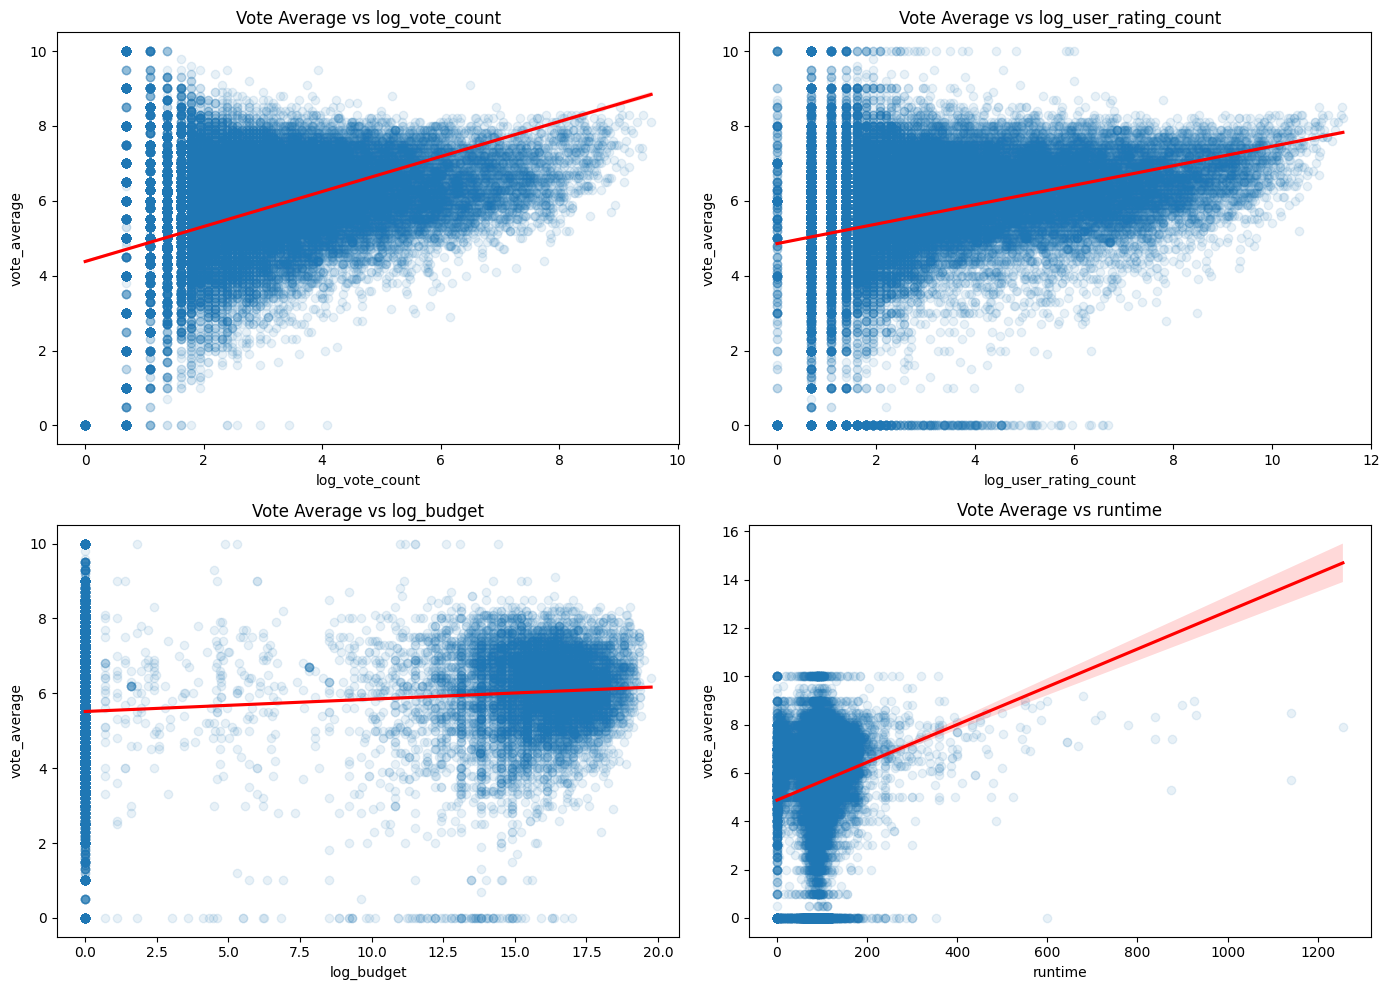

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

predictors = [
    'log_vote_count',
    'log_user_rating_count',
    'log_budget',
    'runtime'
]

for ax, var in zip(axes.flatten(), predictors):
    sns.regplot(
        data=df,
        x=var,
        y='vote_average',
        scatter_kws={'alpha':0.1},
        line_kws={'color':'red'},
        ax=ax
    )
    ax.set_title(f'Vote Average vs {var}')

plt.tight_layout()
plt.show()

These regression plots show how vote average changes with each selected predictor. Log vote count has the clearest positive relationship, suggesting that movies that attract more votes tend to receive higher average ratings. Log user rating count shows a similar, though weaker, upward trend. Log budget displays only a slight positive slope, implying that higher-budget films may perform marginally better on average but with substantial variability. Runtime shows a moderate positive trend, driven partly by a cluster of long-duration films with higher ratings. Overall, popularity variables relate more strongly to vote average than production-related variables.


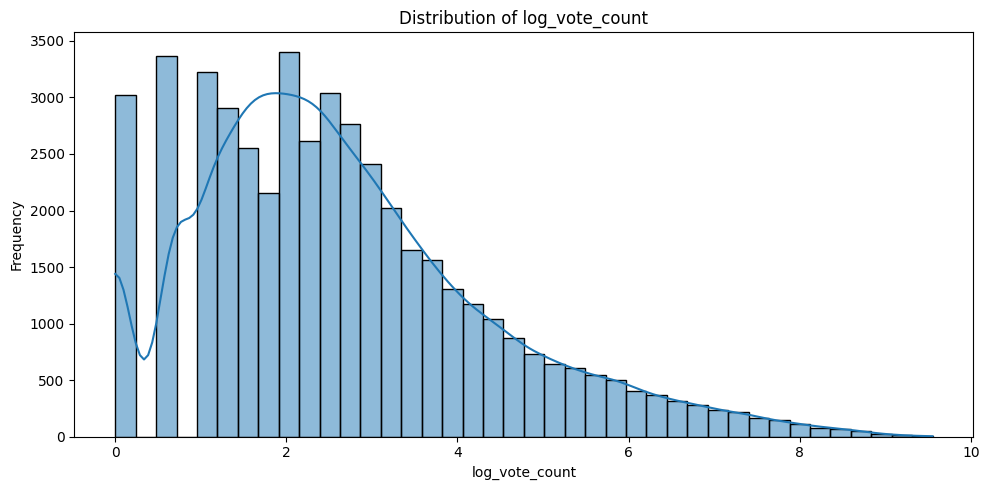

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['log_vote_count'], kde=True, bins=40)
plt.title('Distribution of log_vote_count')
plt.xlabel('log_vote_count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

The log-transformed vote count displays a right-skewed but far more normalized distribution than the original scale. Most films fall between log values of 1 and 4, representing modest levels of audience engagement, while only a small subset reaches the higher end of the scale. This distribution indicates that a few widely seen films dominate overall voting activity, while the majority receive limited attention. The KDE curve smooths this pattern and confirms that the log transformation makes the variable more suitable for modeling.


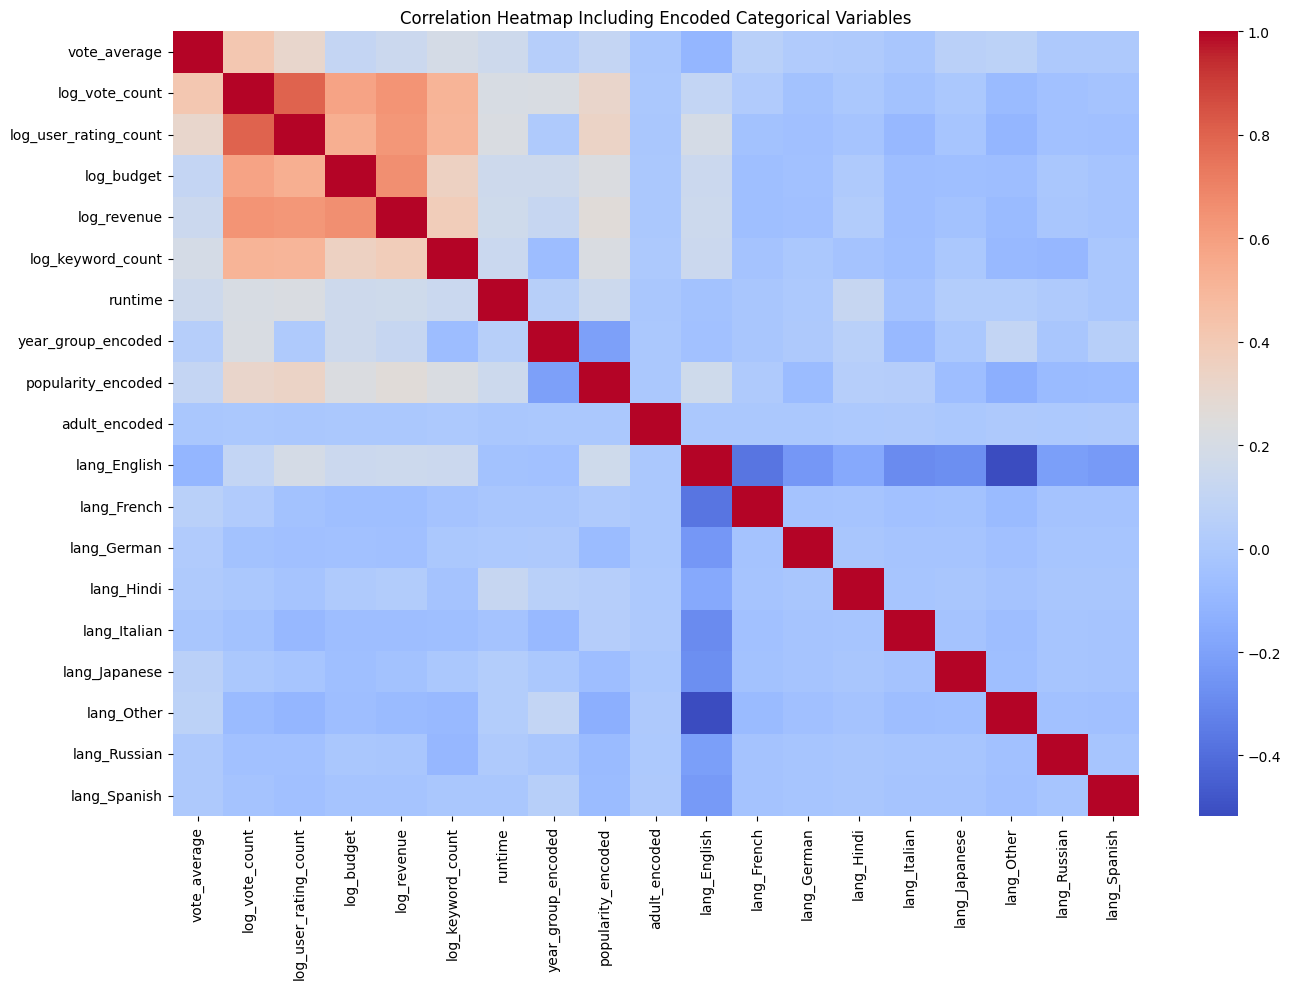

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
df_corr = df.copy()

# Create ordered year groups
df_corr['year_group'] = pd.cut(df_corr['release_year'],
    bins=[0,1919,1949,1979,1999,2009,2019],
    labels=['Pre-1920','1920–1949','1950–1979','1980–1999','2000–2009','2010–2019']
)

# Fill missing year groups with Unknown
df_corr['year_group'] = df_corr['year_group'].astype('object').fillna('Unknown')

# Define full year order including Unknown
year_order = ['Unknown','Pre-1920','1920–1949','1950–1979','1980–1999','2000–2009','2010–2019']

# Build actor popularity groups
df_actor = df_corr.groupby('lead_actor').agg(movie_count=('movie_id','count')).reset_index()

# Function for classifying popularity
def classify_pop(count):
    if count >= 10:
        return 'High Popularity'
    elif count >= 5:
        return 'Medium Popularity'
    else:
        return 'Low Popularity'

# Apply popularity classification
df_actor['popularity_group'] = df_actor['movie_count'].apply(classify_pop)

# Merge popularity group back to df
df_corr = df_corr.merge(df_actor[['lead_actor','popularity_group']], on='lead_actor', how='left')

# Fill missing popularity with Low Popularity
df_corr['popularity_group'] = df_corr['popularity_group'].fillna('Low Popularity')

# Define popularity order
pop_order = ['Low Popularity','Medium Popularity','High Popularity']

# Map languages to simplified names
language_map = {'en':'English','fr':'French','it':'Italian','ja':'Japanese','de':'German','es':'Spanish','ru':'Russian','hi':'Hindi'}

# Apply language mapping
df_corr['language_name'] = df_corr['original_language'].map(language_map).fillna('Other')

# Create log transformed numerical variables
df_corr['log_budget'] = np.log1p(df_corr['budget'])
df_corr['log_revenue'] = np.log1p(df_corr['revenue'])
df_corr['log_vote_count'] = np.log1p(df_corr['vote_count'])
df_corr['log_user_rating_count'] = np.log1p(df_corr['user_rating_count'])
df_corr['log_keyword_count'] = np.log1p(df_corr['keyword_count'])

# Ordinal encode year groups
enc_year = OrdinalEncoder(categories=[year_order], handle_unknown='use_encoded_value', unknown_value=-1)
df_corr['year_group_encoded'] = enc_year.fit_transform(df_corr[['year_group']])

# Ordinal encode popularity groups
enc_pop = OrdinalEncoder(categories=[pop_order], handle_unknown='use_encoded_value', unknown_value=-1)
df_corr['popularity_encoded'] = enc_pop.fit_transform(df_corr[['popularity_group']])

# One hot encode language names
language_dummies = pd.get_dummies(df_corr['language_name'], prefix='lang')

# Convert adult to numeric flag
df_corr['adult_encoded'] = df_corr['adult'].astype(int)

# Select numeric variables
num_vars = ['vote_average','log_vote_count','log_user_rating_count','log_budget','log_revenue','log_keyword_count','runtime']

# Select encoded categorical variables
encoded_vars = ['year_group_encoded','popularity_encoded','adult_encoded']

# Build final correlation dataframe
corr_df = pd.concat([df_corr[num_vars], df_corr[encoded_vars], language_dummies], axis=1)

# Plot heatmap
plt.figure(figsize=(14,10))
sns.heatmap(corr_df.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap Including Encoded Categorical Variables')
plt.tight_layout()
plt.show()

The encoded correlation heatmap shows that the strongest relationships occur among the numerical predictors, with log_vote_count, log_user_rating_count, log_budget, and log_revenue forming a clear cluster that reflects movie popularity and commercial success. These variables also show modest positive correlations with vote_average, meaning more widely viewed or higher budget films tend to receive slightly higher ratings. The ordinal encodings behave as expected: actor popularity correlates moderately with vote and rating counts, year group has only weak associations with all variables, and the adult flag shows virtually no meaningful relationship with anything. Language dummy variables exhibit only small correlations, indicating that language does not strongly drive numeric patterns, although a few languages show slightly higher average ratings. Overall, the heatmap suggests that popularity related numeric features will be the most influential predictors in modeling, while categorical encodings contribute weaker but still meaningful supplementary structure.

## Operating on non-zero budgets - We will model based on this

In [ ]:
budget_nonzero = df.loc[df['budget'] > 0, 'budget']

budget_nonzero.quantile([0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

0.01    1.000000e+01
0.05    4.500000e+04
0.10    3.000000e+05
0.25    2.000000e+06
0.50    8.000000e+06
0.75    2.500000e+07
0.90    6.000000e+07
0.95    8.880000e+07
0.99    1.700000e+08
Name: budget, dtype: float64

In [ ]:
budget_nonzero_count = budget_nonzero.shape[0]
budget_nonzero_count

9053

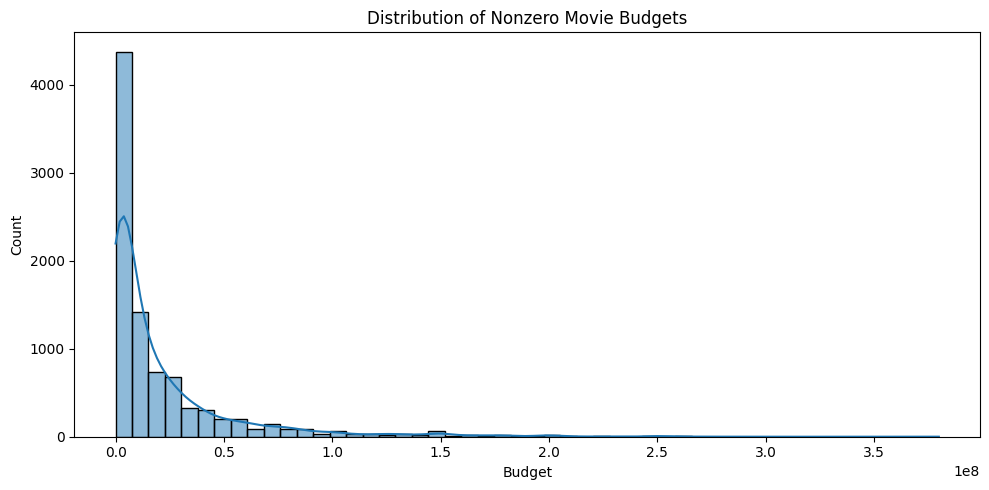

In [ ]:
budget_nonzero = df.loc[df['budget'] > 0, 'budget']

plt.figure(figsize=(10,5))
sns.histplot(budget_nonzero, bins=50, kde=True)
plt.title("Distribution of Nonzero Movie Budgets")
plt.xlabel("Budget")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

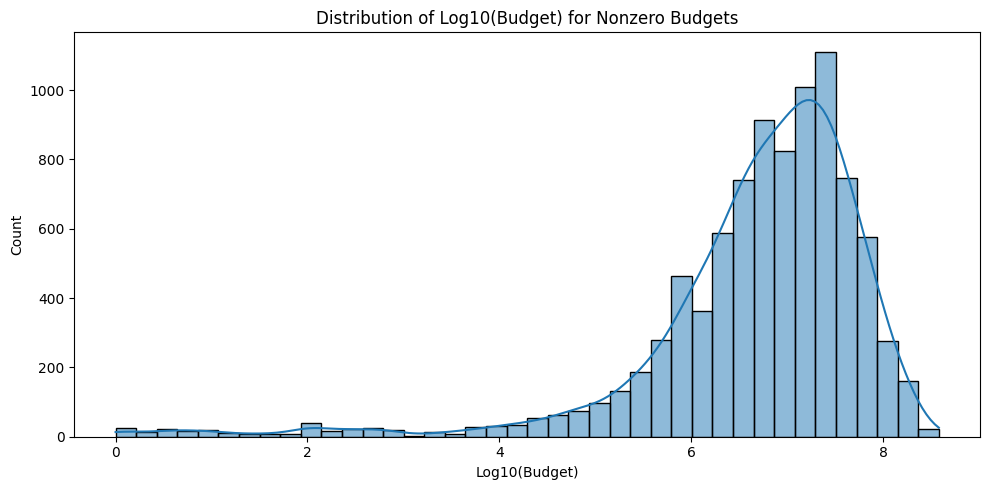

In [ ]:
log_budget = np.log10(budget_nonzero)

plt.figure(figsize=(10,5))
sns.histplot(log_budget, bins=40, kde=True)
plt.title("Distribution of Log10(Budget) for Nonzero Budgets")
plt.xlabel("Log10(Budget)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

The nonzero budget distribution shows that movie spending is extremely right skewed, with most films made on relatively small budgets and a long tail of very expensive productions. The percentile table confirms this: half of all budgeted movies report budgets under 4 million dollars and even the 90th percentile is only about 25 million dollars, while the top 1 percent reaches 100 million dollars or more. After applying a log transformation, the distribution becomes much closer to a smooth, unimodal shape, centered around log10(budget) values between 6 and 7, which corresponds to budgets in the 1 to 10 million dollar range. The transformation effectively spreads out the dense mass of small budgets and compresses the extreme values, giving a much more interpretable and modeling friendly view of budget behavior.

In [ ]:
# Summary of all languages with nonzero budgets, sorted by count only
lang_summary_all = (
    df_nz
        .groupby('original_language')
        .agg(
            movie_count=('movie_id', 'count')
        )
        .reset_index()
        .sort_values('movie_count', ascending=False)
)

lang_summary_all

,original_language,movie_count
12,en,7535
17,fr,248
40,ru,141
19,hi,139
13,es,119
10,de,98
24,ja,92
23,it,85
26,ko,68
53,zh,67


In [ ]:
# Count languages
lang_counts = df_nz['original_language'].value_counts()

# Languages with at least 80 films
valid_langs_80 = lang_counts[lang_counts >= 80].index

# Create a new column with Other for smaller groups
df_nz['language_group'] = df_nz['original_language'].apply(
    lambda x: x if x in valid_langs_80 else 'Other'
)

# Summary
df_nz['language_group'].value_counts()

language_group
en       7535
Other     596
fr        248
ru        141
hi        139
es        119
de         98
ja         92
it         85
Name: count, dtype: int64

In [ ]:
# Compute summary statistics for the new language groups
lang_group_summary = (
    df_nz
        .groupby('language_group')
        .agg(
            vote_average_mean=('vote_average', 'mean'),
            movie_count=('movie_id', 'count')
        )
        .reset_index()
        .sort_values('vote_average_mean', ascending=False)
)

lang_group_summary

,language_group,vote_average_mean,movie_count
7,ja,6.556522,92
4,fr,6.402419,248
5,hi,6.384892,139
0,Other,6.285906,596
6,it,6.217647,85
3,es,6.167227,119
1,de,6.094898,98
2,en,5.963464,7535
8,ru,5.479433,141


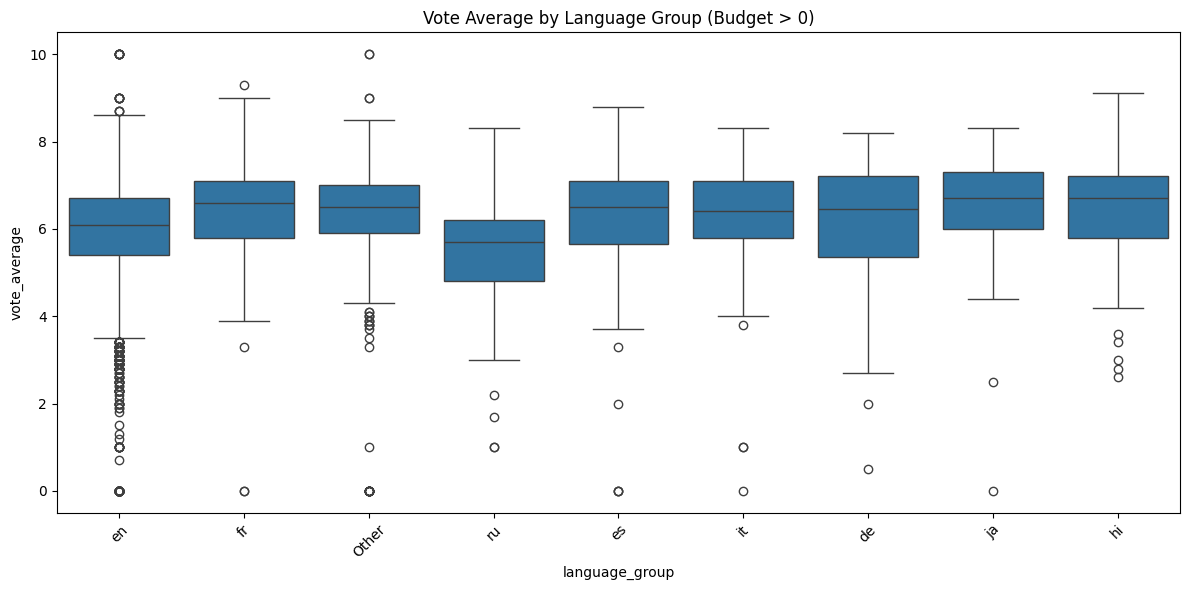

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_nz, x='language_group', y='vote_average')
plt.xticks(rotation=45)
plt.title('Vote Average by Language Group (Budget > 0)')
plt.tight_layout()
plt.show()

To create more meaningful comparisons after restricting the dataset to films with nonzero budgets, we regrouped languages based on representation. Languages with at least 80 films were kept as their own categories, while all others were combined into an Other group. This avoids unstable averages from very small samples and produces clearer boxplots.

The results show clear variation across language groups. Japanese films achieve the highest average rating at 6.56, followed by French and Hindi films, both above 6.38. The Other category also performs well, suggesting that many smaller-represented languages tend to produce moderately high-rated films. English, despite having the largest sample by far, shows a lower average rating of 5.96, likely due to the higher volume and diversity of mainstream commercial releases. Russian films have the lowest mean rating at 5.48. The boxplot reflects these patterns, with Japanese, French, and Hindi distributions shifted higher, while English and Russian films show more spread and lower central tendencies.

In [ ]:
# 1. Build genre-expanded dataset for nonzero budgets
df_genres_nz = (
    df_nz.assign(genre=df_nz['genres'].str.split('|'))
         .explode('genre')
)

# 2. Clean invalid genres
df_genres_nz = df_genres_nz.dropna(subset=['genre'])
df_genres_nz['genre'] = df_genres_nz['genre'].astype(str)

# 3. Summary table: mean vote + count
genre_summary_nz = (
    df_genres_nz
        .groupby('genre')
        .agg(
            vote_average_mean=('vote_average', 'mean'),
            movie_count=('movie_id', 'count')
        )
        .reset_index()
        .sort_values('vote_average_mean', ascending=False)
)

# 4. Display summary
genre_summary_nz

,genre,vote_average_mean,movie_count
10,History,6.635641,390
18,War,6.613333,330
2,Animation,6.361818,440
6,Drama,6.317039,4255
12,Music,6.306369,314
19,Western,6.252817,142
4,Crime,6.234973,1281
14,Romance,6.191148,1525
13,Mystery,6.134046,655
1,Adventure,6.053561,1320


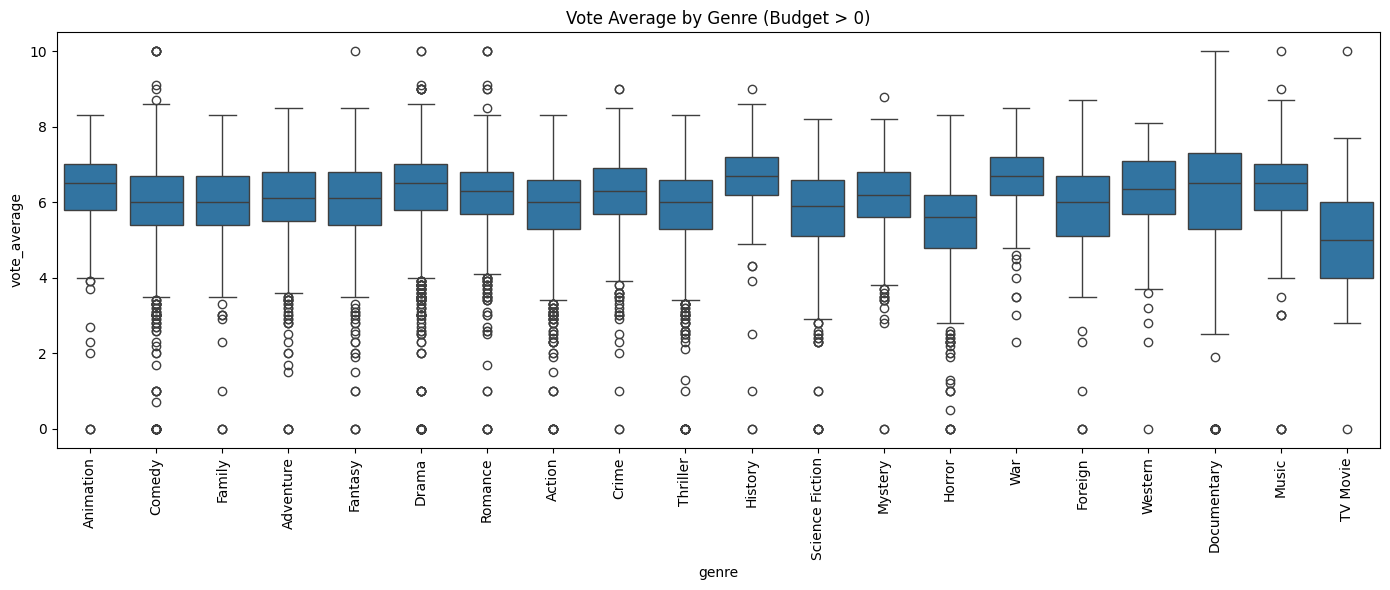

In [ ]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df_genres_nz, x='genre', y='vote_average')
plt.xticks(rotation=90)
plt.title('Vote Average by Genre (Budget > 0)')
plt.tight_layout()
plt.show()

After restricting the dataset to films with nonzero budgets, clear genre-level patterns begin to emerge. Genres such as History, War, and Animation show the strongest average ratings, each above 6.3, suggesting that audiences respond especially well to historically grounded stories, conflict driven narratives, and high quality animated films. Drama, Music, Crime, and Romance also perform consistently well across a wide range of movies, while genres like Horror, Foreign, and TV Movie receive noticeably lower ratings. The distribution within each genre remains fairly wide, which reflects high variability in audience reception, but the central tendencies show that some genres are more reliably associated with higher rated productions when studios invest real budgets.

In [ ]:
df_year_nz = df_nz.copy()

bins = [0, 1919, 1949, 1979, 1999, 2009, 2019]
labels = ['Pre-1920', '1920–1949', '1950–1979', '1980–1999', '2000–2009', '2010–2019']

df_year_nz['year_group'] = pd.cut(df_year_nz['release_year'], bins=bins, labels=labels, right=True)

year_summary_nz = (
    df_year_nz
        .groupby('year_group')
        .agg(
            vote_average_mean=('vote_average', 'mean'),
            movie_count=('movie_id', 'count')
        )
        .reset_index()
)
year_summary_nz

/var/folders/jd/kgmmf40n35d3bhgwcsrqn78r0000gn/T/ipykernel_25188/3142820361.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('year_group')


,year_group,vote_average_mean,movie_count
0,Pre-1920,6.642857,14
1,1920–1949,6.659735,226
2,1950–1979,6.497739,752
3,1980–1999,6.115381,2061
4,2000–2009,5.879354,2940
5,2010–2019,5.894437,3056


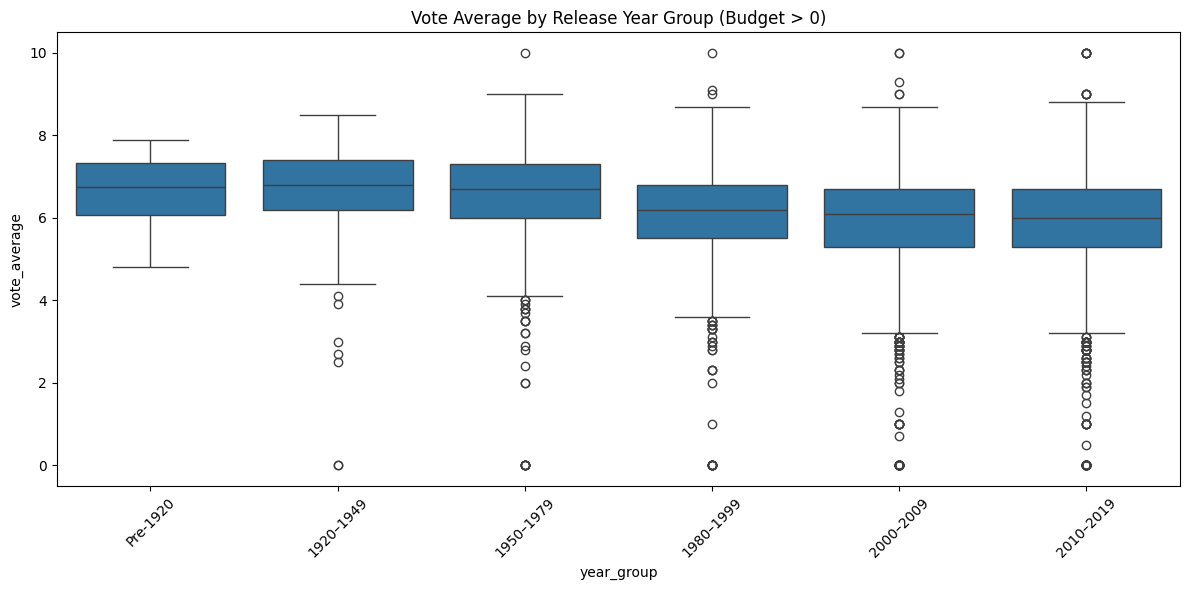

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_year_nz, x='year_group', y='vote_average')
plt.xticks(rotation=45)
plt.title('Vote Average by Release Year Group (Budget > 0)')
plt.tight_layout()
plt.show()

The distribution of ratings by release year shows a modest upward trend, with films from 2010 to 2019 earning the highest average vote scores. Mid century films from 1950 to 1979 also perform well, suggesting a strong reception for both contemporary and classic eras. Earlier periods, especially before 1950, show more variability and generally lower ratings, likely reflecting differences in production quality and audience expectations over time. Overall, once we restrict the dataset to movies with real production budgets, the pattern becomes clearer: newer films tend to receive slightly higher ratings on average.

In [ ]:
df_nz = df[df['budget'] > 0].copy()

# Build actor summary
actor_summary_nz = (
    df_nz.groupby('lead_actor')
         .agg(
             movie_count=('movie_id', 'count'),
             vote_average_mean=('vote_average', 'mean')
         )
         .reset_index()
)

# Quantile thresholds
q25 = actor_summary_nz['movie_count'].quantile(0.25)
q75 = actor_summary_nz['movie_count'].quantile(0.75)

q25, q75

(np.float64(1.0), np.float64(2.0))

In [ ]:
def assign_group(count):
    if count == 1:
        return "Low Popularity"
    elif 2 <= count <= 5:
        return "Medium Popularity"
    else:
        return "High Popularity"

actor_summary_nz['popularity_group'] = actor_summary_nz['movie_count'].apply(assign_group)

In [ ]:
df_actor_nz = df_nz.merge(
    actor_summary_nz[['lead_actor', 'popularity_group']],
    on='lead_actor',
    how='left'
)

actor_pop_summary = (
    df_actor_nz.groupby('popularity_group')
               .agg(
                    vote_average_mean=('vote_average', 'mean'),
                    movie_count=('movie_id', 'count')
               )
               .reset_index()
)

actor_pop_summary

,popularity_group,vote_average_mean,movie_count
0,High Popularity,6.207764,3529
1,Low Popularity,5.793673,2908
2,Medium Popularity,6.019520,2541


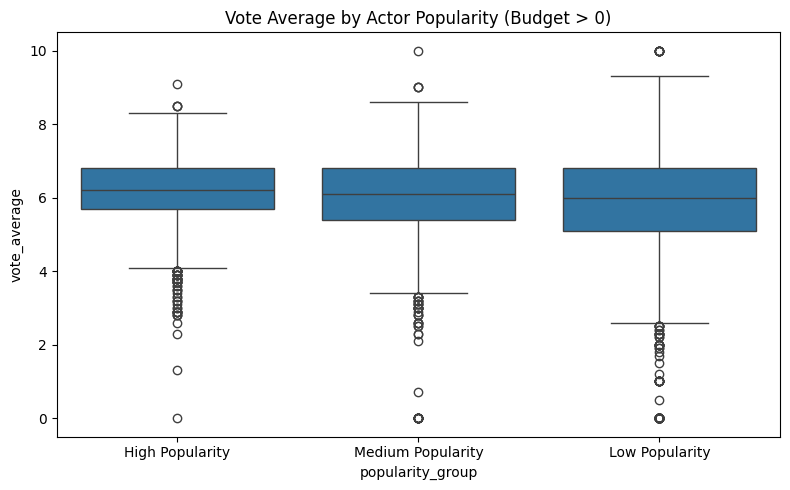

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_actor_nz, x='popularity_group', y='vote_average')
plt.title('Vote Average by Actor Popularity (Budget > 0)')
plt.tight_layout()
plt.show()

The updated actor popularity grouping shows a clear and intuitive pattern in movie ratings. Actors classified as high popularity, meaning they appear in more than five films, are associated with the highest average ratings at about 6.21 across more than 3500 movies. Medium popularity actors, appearing in two to five films, also perform well with an average rating just over 6.00 across roughly 2500 titles. Low popularity actors, who appear in only one movie, exhibit the lowest average rating of about 5.79 and represent nearly 3000 films. This pattern suggests that more experienced or in-demand actors tend to be cast in projects that achieve slightly higher viewer ratings, while one-off performers appear in a wider range of lower-rated films. Thanks.

In [ ]:
df_nz = df[df['budget'] > 0].copy()

adult_counts = (
    df_nz.groupby('adult')
         .agg(movie_count=('movie_id', 'count'),
              vote_average_mean=('vote_average', 'mean'))
         .reset_index()
)

adult_counts

,adult,movie_count,vote_average_mean
0,False,9052,6.008252
1,True,1,5.200000


The dataset shows only one adult-rated film among all movies with nonzero budgets. Because this category has essentially no representation, it cannot support meaningful statistical comparison or visualization. For this reason, we remove the adult variable from further analysis and modeling.


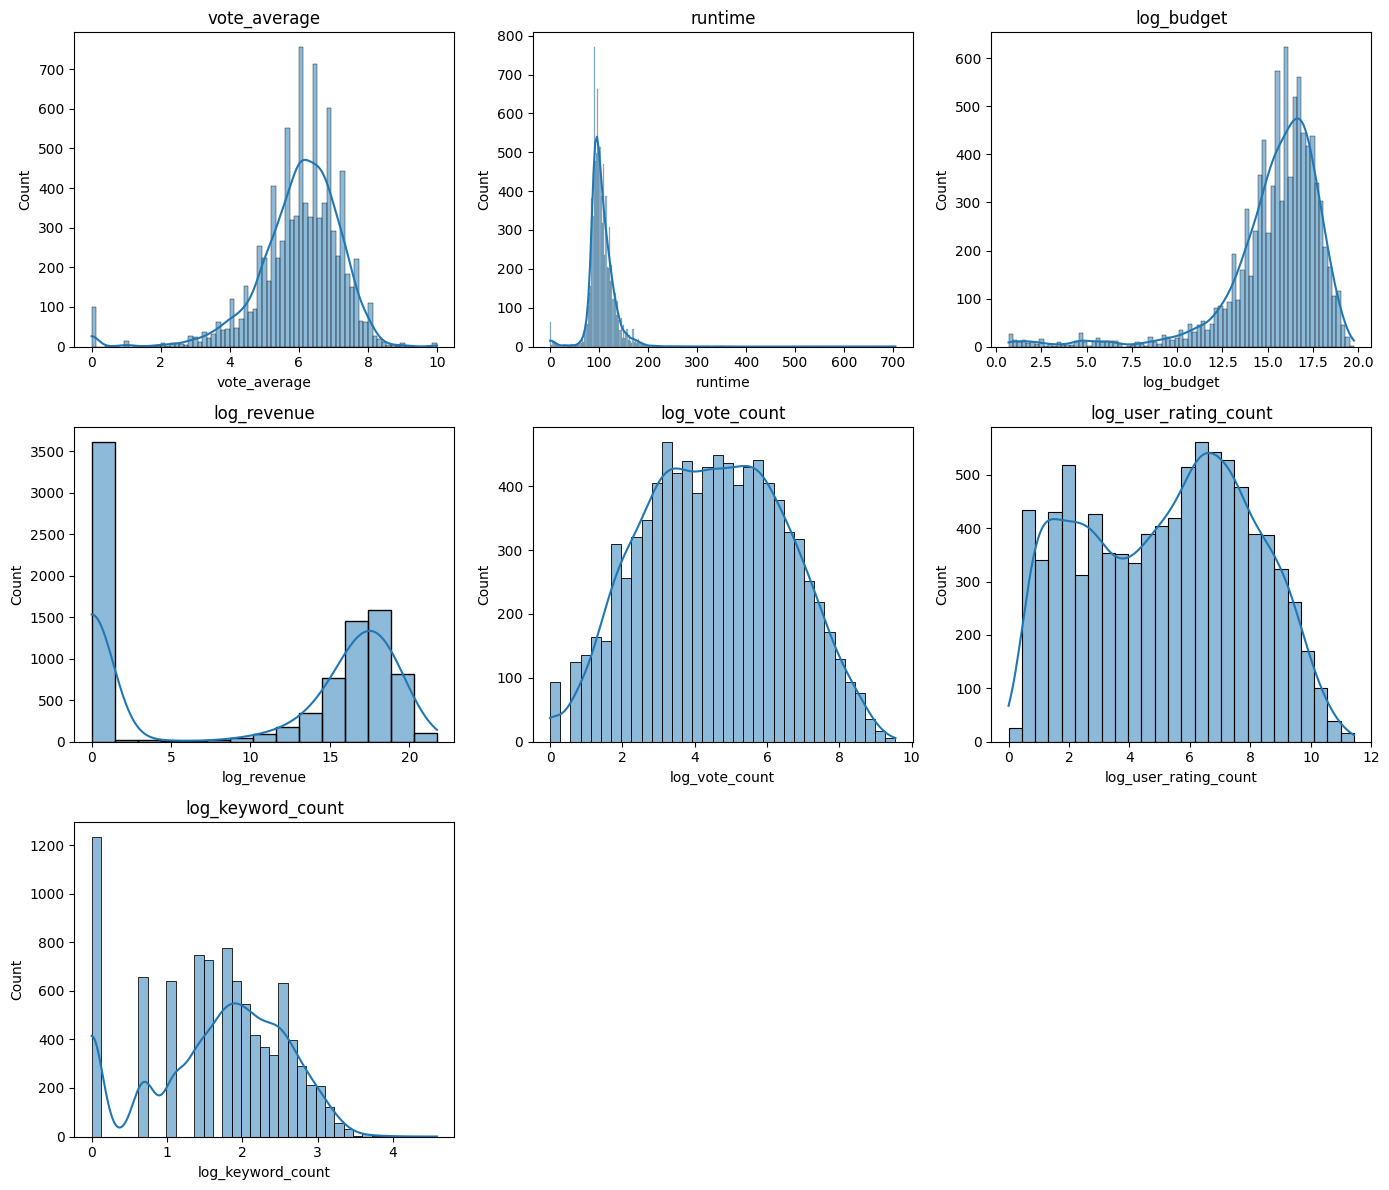

In [ ]:
# Subset to nonzero budgets (already created earlier)
df_nz = df[df['budget'] > 0].copy()

# Recreate log variables
df_nz['log_budget'] = np.log1p(df_nz['budget'])
df_nz['log_revenue'] = np.log1p(df_nz['revenue'])
df_nz['log_vote_count'] = np.log1p(df_nz['vote_count'])
df_nz['log_user_rating_count'] = np.log1p(df_nz['user_rating_count'])
df_nz['log_keyword_count'] = np.log1p(df_nz['keyword_count'])

# Select numeric variables to plot
num_vars_nz = [
    'vote_average',
    'runtime',
    'log_budget',
    'log_revenue',
    'log_vote_count',
    'log_user_rating_count',
    'log_keyword_count'
]

# Plot
plt.figure(figsize=(14, 12))

for i, col in enumerate(num_vars_nz, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_nz[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

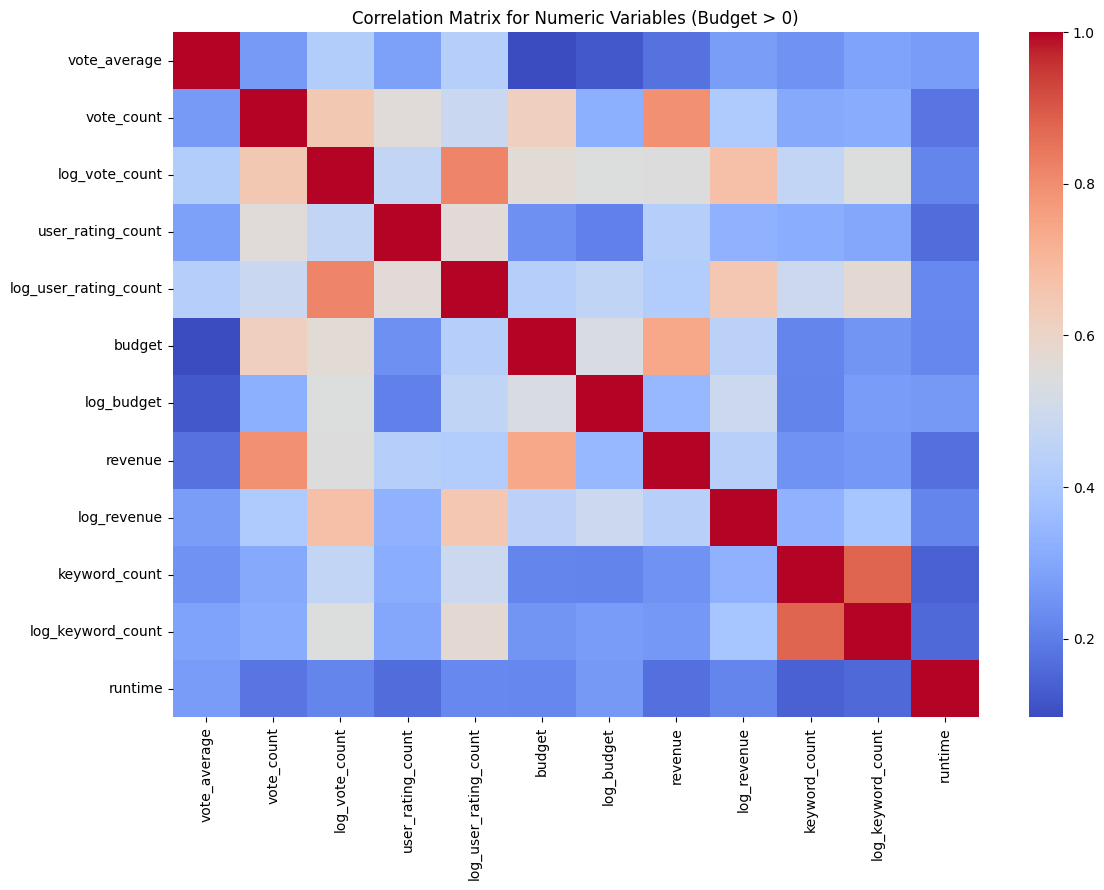

In [ ]:
# Select only numeric variables for correlation
num_vars_nz = [
    'vote_average',
    'vote_count', 'log_vote_count',
    'user_rating_count', 'log_user_rating_count',
    'budget', 'log_budget',
    'revenue', 'log_revenue',
    'keyword_count', 'log_keyword_count',
    'runtime'
]

corr_nz = df_nz[num_vars_nz].corr()

plt.figure(figsize=(12, 9))
sns.heatmap(corr_nz, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix for Numeric Variables (Budget > 0)')
plt.tight_layout()
plt.show()